In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from datetime import timedelta

from time import time_ns
from amftrack.util.dbx import (
    upload_folders,
    load_dbx,
    download,
    get_dropbox_folders_prince,
)
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state, get_dropbox_folders_prince
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from matplotlib import cm
import matplotlib.patches as mpatches
import networkx as nx
from amftrack.pipeline.functions.post_processing.time_plate import *

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
# directory_targ = directory_project
directory_targ = directory_scratch+'myr/'
# directory_targ = directory_project + "myr/"

update_plate_info(directory_targ, local=True, strong_constraint=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
all_folders

In [ ]:
folders = all_folders[all_folders["medium"] == "'0Myr'"]
folders = folders[folders["/Analysis/nx_graph_pruned.p"] == True]
folders

In [ ]:
plates = [
    "63_20230510",
    "34_20230221",
    "61_20230510",
    "64_20230508",
    "33_20230221",
    "35_20230227",
]

In [ ]:
# folders = all_folders[all_folders['unique_id'].isin(plates)]
folders = all_folders
folders

In [ ]:
run_parallel_stitch(
    directory_targ,
    folders,
    32,
    "2:00:00",
    cpus=128,
    node="fat_rome",
    name_job="stitch",
    dependency=False,
    size_x=15,
    size_y=15,
)

In [ ]:
len(all_folders[all_folders["unique_id"].isin(plates)])

In [ ]:
len(all_folders[all_folders["unique_id"].isin(plates)])

In [ ]:
plates = all_folders["unique_id"].unique()
# plates = plates[5:]

In [ ]:
name_job = "Myr"
run_launcher(
    "video_maker.py",
    [directory_targ, name_job, 20],
    plates,
    "24:00:00",
    dependency=True,
    name_job="stitch",
)

In [ ]:
import datetime

results = {}
for plate in plates:
    folders = all_folders.loc[all_folders["unique_id"] == plate].copy()
    folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
    folders = folders.sort_values(by="datetime")
    folders = folders.reset_index()
    folders["days_after_crossing"] = [
        (
            row["datetime"]
            - datetime.datetime(
                int(row["CrossDate"][:4]),
                int(row["CrossDate"][4:6]),
                int(row["CrossDate"][6:]),
            )
        )
        for index, row in folders.iterrows()
    ]
    abs_diff_from_14 = (folders["days_after_crossing"].dt.days - 14).abs()

    # Find the index of the row with the smallest difference
    closest_index = abs_diff_from_14.idxmin()
    exp = Experiment(directory_targ)
    i = closest_index
    exp.load(folders.loc[i:i], suffix="_width")
    for t in range(exp.ts):
        exp.load_tile_information(t)
    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    exp.nx_graph[t] = largest_component_graph
    break

In [ ]:
import networkx as nx

data = {}
for plate in plates[2:]:
    folders = all_folders.loc[all_folders["unique_id"] == plate]
    folders = folders.sort_values(by="datetime")

    exp = Experiment(directory_targ)
    i = 0
    exp.load(folders.iloc[i : i + 1], suffix="_width")
    for t in range(exp.ts):
        exp.load_tile_information(t)

    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    exp.nx_graph[t] = largest_component_graph
    area, length = get_area(exp, 0)[1], get_length_tot(exp, 0)[1]
    strain = folders["strain"].iloc[0]
    unique_id = folders["unique_id"].iloc[0]
    data[unique_id] = {"strain": strain, "density": length / area}
    print(length / area)

In [ ]:
pd.DataFrame(data).transpose().to_csv("myristate.csv")

In [4]:
plate = "68_20230501"
folders = all_folders.loc[all_folders["unique_id"] == plate]
# folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled.p"] == True]
# folders = folders.sort_values(by="datetime")

In [5]:
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 0
exp.load(folders.iloc[i : i + 1], suffix="_width")
for t in range(exp.ts):
    exp.load_tile_information(t)

2023-05-23 22:52:00


In [6]:
import networkx as nx

G = exp.nx_graph[t]
components = nx.connected_components(G)

# Find the largest connected component
largest_component = max(components, key=len)

# Create a new graph representing the largest connected component
largest_component_graph = G.subgraph(largest_component)
exp.nx_graph[t] = largest_component_graph

In [ ]:
from amftrack.pipeline.functions.post_processing.time_plate import *

area, length = get_area(exp, 0)[1], get_length_tot(exp, 0)[1]

In [ ]:
length / area

In [ ]:
get_area(exp, 0)

In [7]:
from amftrack.pipeline.functions.image_processing.experiment_util import *

In [8]:
def plot_paper(
    exp: Experiment,
    t: int,
    color_fun: Callable,
    region=None,
    intervals=[[1, 4], [4, 6], [6, 10], [10, 20]],
    cmap=cm.get_cmap("Reds", 100),
    plot_cmap=False,
    v_max=10,
    v_min=0,
    nodes: List[Node] = [],
    downsizing=5,
    dilation=5,
    save_path="",
    color_seed=12,
    dpi=None,
    show_background=True,
    label_colorbar="Width ($\mu m)$",
    figsize=(36, 24),
    figax=None,
    alpha=0.5,
) -> None:
    """
    Plot the width for all the edges at a given timestep.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param color_fun: edge -> float a function of edges that needs to be color plotted

    :param nodes: list of nodes to plot
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param intervals: different width intervals that will be given different colors
    :param cmap: a colormap to map width to color
    :param plot_cmap: a boolean, whether or not to plot with cmap
    :param v_max: the max width for the colorbar/colormap
    """
    DIM_X, DIM_Y = get_dimX_dimY(exp)

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X
        region[1][1] += DIM_Y

    edges = get_all_edges(exp, t)
    if figax is None:
        fig = plt.figure(
            figsize=figsize
        )  # width: 30 cm height: 20 cm # TODO(FK): change dpi
        ax = fig.add_subplot(111)
    else:
        fig, ax = figax

    # Give colors to edges
    default_color = 1000
    colors = []
    widths = []
    for edge in edges:
        width = color_fun(edge)
        widths.append(width)
        if not plot_cmap:
            color = default_color
            for i, interval in enumerate(intervals):
                if interval[0] <= width and width < interval[1]:
                    color = i + color_seed
            colors.append(color)
    if plot_cmap:
        colors = [cmap((width - v_min) / (v_max - v_min)) for width in widths]
    # 0/ Make color legend
    def convert(c):
        c_ = c / 255
        return (c_[0], c_[1], c_[2])

    # 1/ Image layer
    if show_background:
        im, f = reconstruct_image_from_general(
            exp,
            t,
            downsizing=downsizing,
            region=region,
            prettify=False,
            white_background=False,
        )
        f_int = lambda c: f(c).astype(int)

    # 2/ Edges layer
    color_list = (
        [(np.array(color) * 255).astype(int) for color in colors] if plot_cmap else None
    )
    from_edges = reconstruct_skeletton_from_edges(
        exp,
        t,
        edges=edges,
        region=region,
        color_seeds=colors,
        color_list=color_list,
        downsizing=downsizing,
        dilation=dilation,
        timestep=False,
    )
    skel_im, _ = from_edges
    if show_background:
        new_region = [
            f_int(region[0]),
            f_int(region[1]),
        ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 3/ Fusing layers
    if show_background:
        ax.imshow(im, cmap="gray", interpolation="none")
    ax.imshow(skel_im, alpha=alpha, interpolation="none", aspect="equal")

    # 3/ Plotting the Nodes
    size = 5
    bbox_props = dict(boxstyle="circle", fc="white")
    for node in nodes:
        c = node.pos(t)
        if is_in_bounding_box(c, region):
            c = f(node.pos(t))
            node_text = ax.text(
                c[1],
                c[0],
                str(node.label),
                ha="center",
                va="center",
                size=size,
                bbox=bbox_props,
            )
    ax.set_xticks([])
    ax.set_yticks([])
    return fig, ax

In [ ]:
plates = [
    "62_20230511",
    "49_20230510",
    "60_20230508",
    "68_20230501",
    "14_20230301",
    "58_20230511",
    "1_20230221",
    "51_20230511",
    "48_20230301",
    "33_20230221",
    "46_20230221",
]

In [ ]:
plates = folders["unique_id"].unique()

In [ ]:
folders2 = all_folders[all_folders["medium"] == "'0Myr'"]

In [ ]:
plates = folders2[folders2["Plate"].isin(plates_num)]["unique_id"].unique()

In [ ]:
plates

In [ ]:
plates_num = ["31", "33", "34", "35", "61", "62", "63", "64", "67", "68", "69", "72"]

In [ ]:
plates[6:]

In [ ]:
plates

In [ ]:
import datetime

results = {}
for plate in plates[0:]:
    folders = all_folders.loc[all_folders["unique_id"] == plate].copy()
    folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
    folders = folders.sort_values(by="datetime")
    folders = folders.reset_index()
    folders["days_after_crossing"] = [
        (
            row["datetime"]
            - datetime.datetime(
                int(row["CrossDate"][:4]),
                int(row["CrossDate"][4:6]),
                int(row["CrossDate"][6:]),
            )
        )
        for index, row in folders.iterrows()
    ]
    abs_diff_from_14 = (folders["days_after_crossing"].dt.days - 15).abs()

    # Find the index of the row with the smallest difference
    closest_index = abs_diff_from_14.idxmin()
    exp = Experiment(directory_targ)
    i = closest_index
    i = len(folders) - 1
    # i=0
    exp.load(folders.loc[i:i], suffix="")
    for t in range(exp.ts):
        exp.load_tile_information(t)
    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    exp.nx_graph[t] = largest_component_graph
    # if abs_diff_from_14.iloc[0]<=2:
    print(get_length_tot(exp, 0)[1], abs_diff_from_14)
    break

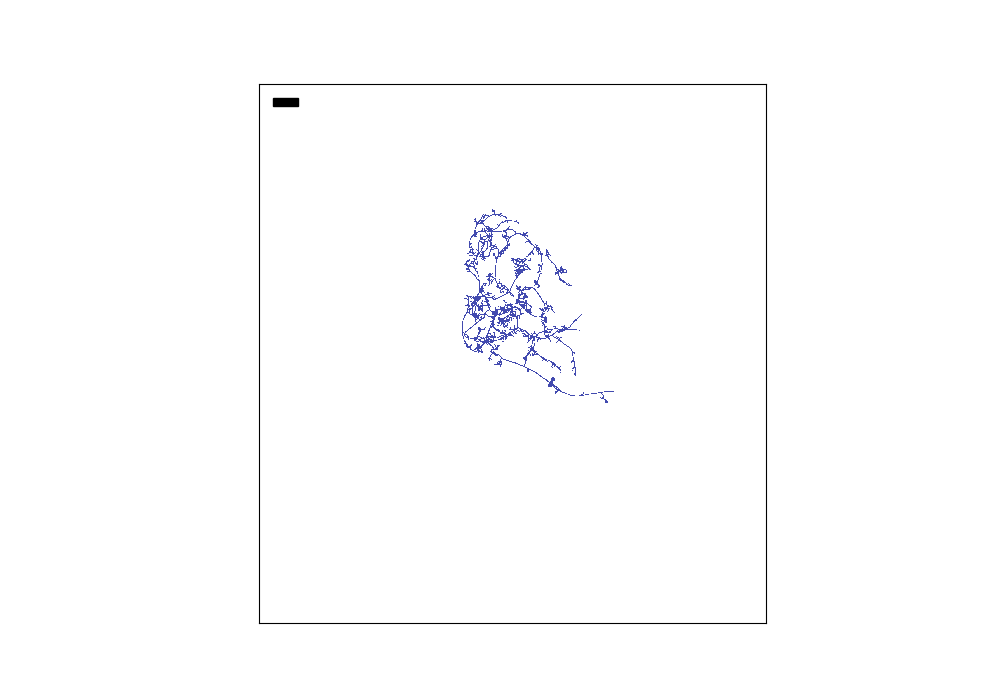

In [11]:
vmax = 10
vmin = 0
downsizing = 10
width = 10
height = 7
region = [[0, 0], [4000 * 5, 10000 * 5]]
nodes = get_all_nodes(exp, t)

fig, ax = plot_paper(
    exp,
    t,
    lambda edge: 5,
    # region=region,
    # nodes = nodes,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=False,
    show_background=False,
    dilation=5,
    figsize=(width, height),
    alpha=1,
    downsizing=downsizing,
)
rect = mpatches.Rectangle((100, 100), 1000 * 1.725 / downsizing, 50, color="black")

# Add the rectangle to the plot
ax.add_patch(rect)
# time = int(
#     (
#         folders.iloc[i : i + 1]["datetime"].iloc[0] - folders.iloc[0]["datetime"]
#     ).total_seconds()
#     / 3600
# )
# # plt.savefig(os.path.join("figures",f"{folders.iloc[i:i+1]['datetime'].iloc[0]}_{plate}.pdf"), transparent=True, bbox_inches='tight')
# ax.text(3500, 400, f"t = {time}h", size=6)
plt.savefig(
    os.path.join("figures", f"myristate.pdf"),
    transparent=True,
    bbox_inches="tight",
)

In [ ]:
from amftrack.pipeline.functions.post_processing.time_plate import *

data = {}
for plate in plates:
    folders = all_folders.loc[all_folders["unique_id"] == plate].copy()
    folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
    folders = folders.sort_values(by="datetime")
    folders = folders.reset_index()
    folders["days_after_crossing"] = [
        (
            row["datetime"]
            - datetime.datetime(
                int(row["CrossDate"][:4]),
                int(row["CrossDate"][4:6]),
                int(row["CrossDate"][6:]),
            )
        )
        for index, row in folders.iterrows()
    ]
    if len(folders) > 0:
        abs_diff_from_14 = (folders["days_after_crossing"].dt.days - 14).abs()

        # Find the index of the row with the smallest difference
        closest_index = abs_diff_from_14.idxmin()
        exp = Experiment(directory_targ)
        i = closest_index
        exp.load(folders.loc[i:i], suffix="_width")
        for t in range(exp.ts):
            exp.load_tile_information(t)
        G = exp.nx_graph[t]
        try:

            components = nx.connected_components(G)

            # Find the largest connected component
            largest_component = max(components, key=len)

            # Create a new graph representing the largest connected component
            largest_component_graph = G.subgraph(largest_component)
            exp.nx_graph[t] = largest_component_graph
            area, length = get_area(exp, 0)[1], get_length_tot(exp, 0)[1]
            strain = folders["strain"].iloc[0]
            unique_id = folders["unique_id"].iloc[0]
            medium = folders["medium"].iloc[0]
            data[unique_id] = {
                "strain": strain,
                "density": length / area,
                "medium": medium,
            }
        except:
            print(plate)
        print(length / area)

In [ ]:
pd.DataFrame(data).transpose().to_csv("control.csv")

In [ ]:
pd.DataFrame(data).transpose()